# Reader Implementation Tutorial

This notebook aims to guide you through creating the reader for the raw files logged by a disdrometer device. 

In first place, this notebook will provide you with functions that will display and enable to investigate the content of your raw data files.

Successively, you will define a series of parameters defining the reader behaviour. These pieces of code will be consolidated in the [template_reader_raw_text_data.py](https://github.com/ltelab/disdrodb/blob/main/disdrodb/l0/readers/template_reader_raw_text_data.py) file to generate a DISDRODB L0 reader.

In this notebook, we uses a lightweight dataset for illustratory purposes. You may use it and readapt it for exploring your own dataset, when preparing a new reader. 

Following the documentation in [How to Contribute New Data to DISDRODB](https://disdrodb.readthedocs.io/en/latest/contribute_data.html), you should have already: 

* defined the metadata for the stations you aim to define the reader
* copied the raw data within the correct folder of the local DISDRODB archive
* copied the [template_reader_raw_text_data.py](https://github.com/ltelab/disdrodb/blob/main/disdrodb/l0/readers/template_reader_raw_text_data.py), place it in the correct `disdrodb.l0.readers.<SENSOR_NAME>.<DATA_SOURCE>` directory and renamed it as `<READER_NAME>.py`.
* defined the metadata `reader` reference `<DATA_SOURCE>/<READER_NAME>` pointing to the reader you are going to create in this tutorial.


For this tutorial, we have prepared some sample data in the folder [data/DISDRODB](https://github.com/ltelab/disdrodb/tree/main/data/DISDRODB) of the [disdrodb](https://github.com/ltelab/disdrodb/) repository. In this tutorial, this `data/DISDRODB` directory will act as toy local DISDRODB Data Archive.

The data corresponds to some measurements taken at two stations (named `60` and `61`) during two days of a field campaign led by the EPFL LTE laboratory in 2018. 

The metadata information for these two stations are already defined in the DISDRODB Metadata Archive.

```
  📁 DISDRODB
  ├── 📁 RAW
      ├── 📁 EPFL
          ├── 📁 LOCARNO_2018
              ├── 📁 data
                  ├── 📁 60
                  ├── 📜 file60_20180817.dat.gz
                  ├── 📜 file60_20180818.dat.gz
                  ├── 📁 61
                  ├── 📜 file61_20180817.dat.gz
                  ├── 📜 file61_20180818.dat.gz
             
```

To start the tutorial, we thus copy such data to a temporary local DISDRODB Data Archive:

In [ ]:
import os
import shutil

import disdrodb

# Define the path to the temporary local DISDRODB Data Archive
base_dir = "/tmp/data/DISDRODB"

In [ ]:
# Copy the sample data the temporary local DISDRODB Data Archive
root_path = os.path.dirname(os.getcwd())  # software root path
sample_archive_base_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "DISDRODB")
shutil.copytree(sample_archive_base_dir, base_dir)

'/tmp/data/DISDRODB'

Let's also check that the DISDRODB Metadata Archive has been specified correctly in the DISDRODB configuration file.

If calling the following cell raise an error, please check again the steps described in the [Quick Start](https://disdrodb.readthedocs.io/en/latest/quick_start.html) section of the software documentation on how to download the DISDRODB Metadata Archive and set up the DISDRODB configuration file !


In [ ]:
metadata_dir = disdrodb.get_metadata_dir()
print(metadata_dir)

/home/ghiggi/Projects/DISDRODB-METADATA/DISDRODB


Now we are ready to start the tutorial and define the DISDRODB reader required to process the raw data files and create DISDRODB products.

The goal is to define a function accepting a file path and returning a pandas dataframe compliant with the DISDRODB L0 standards.

Let's start by importing the required packages and modules.

In [ ]:
from pprint import pprint

import pandas as pd
from IPython.display import display

import disdrodb
from disdrodb.api.checks import check_sensor_name
from disdrodb.l0.check_standards import check_l0a_column_names

# L0A processing
from disdrodb.l0.l0a_processing import (
    read_raw_text_file,
    read_raw_text_files,
    sanitize_df,
)

# L0B processing
from disdrodb.l0.l0b_processing import (
    create_l0b_from_l0a,
)

# Tools to develop the reader
from disdrodb.l0.template_tools import (
    check_column_names,
    get_df_columns_unique_values_dict,
    infer_column_names,
    print_df_column_names,
    print_df_columns_unique_values,
    print_df_first_n_rows,
    print_df_random_n_rows,
    print_valid_l0_column_names,
)
from disdrodb.metadata.checks import check_metadata_compliance
from disdrodb.routines import (
    run_disdrodb_l0_station,
    run_disdrodb_l0a_station,
    run_disdrodb_l1_station,
)
from disdrodb.utils.time import infer_sample_interval

## 1. Define station metadata and list raw data files

Here below we define the station arguments required to search the metadata in the DISDRODB Metadata Archive
and the raw data files in the local DISDRODB Data Archive.

When developing your own reader, you should adapt these station arguments to your own station.

In [ ]:
data_source = "EPFL"
campaign_name = "LOCARNO_2018"
station_name = "60"

With the following function we can easily read the metadata of the station
present in the DISDRODB Metadata Archive. 

In [ ]:
metadata = disdrodb.read_station_metadata(
    metadata_dir=metadata_dir,
    data_source=data_source,
    campaign_name=campaign_name,
    station_name=station_name,
)
pprint(metadata)

{'acknowledgement': '',
 'altitude': 1671,
 'authors': 'Alexis Berne, Jacopo Grazioli',
 'authors_url': 'https://orcid.org/0000-0003-4977-1204, '
                'https://orcid.org/0000-0002-7097-3946',
 'calibration_certification_date': '',
 'calibration_certification_url': '',
 'calibration_sensitivity': '',
 'campaign_name': 'LOCARNO_2018',
 'comment': 'Installation terminated early because of instrumental issues. '
            'Instrument installed within a MeteoSwiss ground station',
 'contact': 'alexis.berne@epfl.ch',
 'contact_information': 'http://lte.epfl.ch',
 'continent': 'Europe',
 'contributors': 'Alexis Berne, Jacopo Grazioli',
 'country': 'Switzerland',
 'data_source': 'EPFL',
 'deployment mode': '',
 'deployment_status': 'terminated',
 'description': '',
 'disdrodb_data_url': '',
 'documentation': '',
 'doi': '',
 'firmware_dsp': '',
 'firmware_iop': '',
 'firmware_version': '',
 'history': '',
 'institution': 'Laboratoire de Teledetection Environnementale - Ecole '
   

To proceed with the design of the reader, if you have not yet defined the metadata of your station, only the ``sensor_name`` and ``raw_data_glob_pattern`` keys are required:

In [ ]:
sensor_name = metadata.get("sensor_name")  # One of disdrodb.available_sensor_names()
print(f"Sensor name: {sensor_name}")
check_sensor_name(sensor_name)

Sensor name: OTT_Parsivel


In [ ]:
glob_pattern = metadata.get("raw_data_glob_pattern")
print(f"raw_data_glob_pattern: {glob_pattern}")

raw_data_glob_pattern: *.dat*


The `raw_data_glob_pattern` key specify the [glob pattern](https://en.wikipedia.org/wiki/Glob_(programming)) used by DISDRODB to search the raw data files in the local DISDRODB Data Archive. 

In this example, we are looking for all the files with the `.dat.gz` extension in the `data` folder of the local DISDRODB Data Archive.
Thus we define the `raw_data_glob_pattern` key as `*.dat.gz`. Note that also `"*.dat.*"` or `"file*.dat.gz"` would have worked.

When you will reuse/adapt this tutorial to implement the reader for your station,
you will have to adapt the `glob_pattern` string, since is very likely that the file name format will have changed.

If the `raw_data_glob_pattern` is specified correctly, the function ``find_files`` in the next cell will return the list of the raw data files matching the pattern. 

  




In [ ]:
filepaths = disdrodb.find_files(
    base_dir=base_dir,
    data_source=data_source,
    campaign_name=campaign_name,
    station_name=station_name,
    product="RAW",
    glob_pattern=glob_pattern,
)

print(filepaths)

['/tmp/data/DISDRODB/RAW/EPFL/LOCARNO_2018/data/60/file60_20180817.dat.gz', '/tmp/data/DISDRODB/RAW/EPFL/LOCARNO_2018/data/60/file60_20180818.dat.gz']


Once you determined the correct glob pattern to find the raw data of the station, it is time to try reading the raw files. 

## 2. Read raw text files into pandas

To read the raw data files, we will use the `read_raw_text_file` function.
It's a tiny wrapper around the `pandas.read_csv` function, which allows to read text files into a pandas DataFrame.

By manually looking at the raw text files, you have to identify
the separator (`delimiter`) used in the file, the header lines and the columns names.

The arguments accepted by `pandas.read_csv` are available here [here](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). 

Typically, adapting the `reader_kwargs` dictionary values here below is enough to read the raw text files into a `pandas.DataFrame`.

Now let's have a look at one raw data file, and let's try to customize the `reader_kwargs` dictionary to read the data correctly.

In [ ]:
reader_kwargs = {}

# - Define delimiter
reader_kwargs["delimiter"] = ","

# - Avoid first column to become df index !!!
reader_kwargs["index_col"] = False

# Since column names are expected to be passed explicitly, header is set to None
reader_kwargs["header"] = None

# - Number of rows to be skipped at the beginning of the file
reader_kwargs["skiprows"] = None

# - Define behaviour when encountering bad lines
reader_kwargs["on_bad_lines"] = "skip"

# - Define reader engine
#   - C engine is faster
#   - Python engine is more feature-complete
reader_kwargs["engine"] = "python"

# - Define on-the-fly decompression of on-disk data
#   - Available: gzip, bz2, zip
reader_kwargs["compression"] = "infer"

# - Strings to recognize as NA/NaN and replace with standard NA flags
#   - Already included: '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN',
#                       '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A',
#                       'NA', 'NULL', 'NaN', 'n/a', 'nan', 'null'
reader_kwargs["na_values"] = ["na", "", "error"]

In [ ]:
# Select one file
filepath = filepaths[0]

# Try to read the raw file
df_raw = read_raw_text_file(filepath, column_names=None, reader_kwargs=reader_kwargs)

# Print the dataframe
print(f"Dataframe for the file {os.path.basename(filepath)} :")
display(df_raw)

Dataframe for the file file60_20180817.dat.gz :


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,362511,4612.0301,00847.4977,01-08-2018 12:44:30,NaN,OK,0000.000,0056.49,00,00,...,035,0.06,24.9,0,005.649,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
1,362512,4612.0301,00847.4978,01-08-2018 12:45:01,NaN,OK,0000.000,0056.49,00,00,...,035,0.06,24.9,0,005.649,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
2,362513,4612.0301,00847.4985,01-08-2018 12:45:30,NaN,OK,0000.000,0056.49,00,00,...,035,0.06,24.9,0,005.649,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
3,362514,4612.0305,00847.4990,01-08-2018 12:46:01,NaN,OK,0000.000,0056.49,00,00,...,035,0.05,24.9,0,005.649,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
4,362515,4612.0303,00847.4992,01-08-2018 12:46:31,NaN,OK,0000.000,0056.49,00,00,...,034,0.06,24.9,0,005.649,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4736,367249,4612.0313,00847.4956,03-08-2018 04:13:25,NaN,OK,0000.000,0056.71,00,00,...,015,0.06,24.9,0,005.671,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
4737,367250,4612.0313,00847.4955,03-08-2018 04:13:56,NaN,OK,0000.000,0056.71,00,00,...,015,0.06,24.9,0,005.671,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
4738,367251,4612.0313,00847.4955,03-08-2018 04:14:26,NaN,OK,0000.000,0056.71,00,00,...,015,0.06,24.9,0,005.671,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
4739,367252,4612.0313,00847.4954,03-08-2018 04:14:55,NaN,OK,0000.000,0056.71,00,00,...,015,0.06,24.9,0,005.671,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0


In [ ]:
print("Column names:", df_raw.columns)
print("Row Index:", df_raw.index)

Column names: Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23],
      dtype='int64')
Row Index: RangeIndex(start=0, stop=4741, step=1)


Here we expect the `df_raw` to have: 
- numeric column names (i.e.  `Index`) 
- numeric row index (i.e. `RangeIndex`)  

If the structure of the dataframe looks fine (no header and no row index), you are on the good track ! 

If it is necessary to skip some header lines, you can adapt the `skiprows` argument to specify the number of lines to skip at the beginning of the file.

Once the ``reader_kwargs`` dictionary is correctly specified, it's to identify the dataframe columns names !

> 🚨 The `reader_kwargs` dictionary will be copied to the reader function in section 4 of this tutorial. 

## 3 Define dataframe column names

Here below we print the values of each column for the first 3 dataframe rows. Feel free to change the value of `n` to see more/less rows !

In [ ]:
print_df_first_n_rows(df_raw, n=2, print_column_names=False)

 - Column 0 :
      ['362511' '362512' '362513']
 - Column 1 :
      ['4612.0301' '4612.0301' '4612.0301']
 - Column 2 :
      ['00847.4977' '00847.4978' '00847.4985']
 - Column 3 :
      ['01-08-2018 12:44:30' '01-08-2018 12:45:01' '01-08-2018 12:45:30']
 - Column 4 :
      [nan nan nan]
 - Column 5 :
      ['OK' 'OK' 'OK']
 - Column 6 :
      ['0000.000' '0000.000' '0000.000']
 - Column 7 :
      ['0056.49' '0056.49' '0056.49']
 - Column 8 :
      ['00' '00' '00']
 - Column 9 :
      ['00' '00' '00']
 - Column 10 :
      ['-9.999' '-9.999' '-9.999']
 - Column 11 :
      ['9999' '9999' '9999']
 - Column 12 :
      ['12611' '12617' '12600']
 - Column 13 :
      ['00000' '00000' '00000']
 - Column 14 :
      ['035' '035' '035']
 - Column 15 :
      ['0.06' '0.06' '0.06']
 - Column 16 :
      ['24.9' '24.9' '24.9']
 - Column 17 :
      ['0' '0' '0']
 - Column 18 :
      ['005.649' '005.649' '005.649']
 - Column 19 :
      ['000' '000' '000']
 - Column 20 :
      ['-9.999,-9.999,-9.999,-9

Alternatively, you can also call the dataframe `head(n)` method to print the first `n` rows of the dataframe.

In [ ]:
df_raw.head(3)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,362511,4612.0301,00847.4977,01-08-2018 12:44:30,NaN,OK,0000.000,0056.49,00,00,...,035,0.06,24.9,0,005.649,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
1,362512,4612.0301,00847.4978,01-08-2018 12:45:01,NaN,OK,0000.000,0056.49,00,00,...,035,0.06,24.9,0,005.649,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
2,362513,4612.0301,00847.4985,01-08-2018 12:45:30,NaN,OK,0000.000,0056.49,00,00,...,035,0.06,24.9,0,005.649,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0


To further analyze the data, with `print_df_random_n_rows` you can print the content of n rows picked randomly.

You can call this command multiple times to see different rows each time and better understand the content of the dataframe.

In [ ]:
print_df_random_n_rows(df_raw, n=6, print_column_names=False)

 - Column 0 :
      ['363481' '365080' '366272' '364685' '363829' '366869']
 - Column 1 :
      ['4612.0310' '4612.0324' '4612.0308' '4612.0294' '4612.0302' '4612.0289']
 - Column 2 :
      ['00847.4952' '00847.4964' '00847.4937' '00847.4952' '00847.4945'
 '00847.4959']
 - Column 3 :
      ['01-08-2018 20:49:31' '02-08-2018 10:09:01' '02-08-2018 20:05:00'
 '02-08-2018 06:51:30' '01-08-2018 23:43:31' '03-08-2018 01:03:31']
 - Column 4 :
      [nan nan nan nan nan nan]
 - Column 5 :
      ['OK' 'OK' 'OK' 'OK' 'OK' 'OK']
 - Column 6 :
      ['0000.000' '0000.000' '0000.000' '0000.000' '0000.000' '0000.000']
 - Column 7 :
      ['0056.67' '0056.67' '0056.71' '0056.67' '0056.67' '0056.71']
 - Column 8 :
      ['00' '00' '00' '00' '00' '00']
 - Column 9 :
      ['00' '00' '00' '00' '00' '00']
 - Column 10 :
      ['-9.999' '-9.999' '-9.999' '-9.999' '-9.999' '-9.999']
 - Column 11 :
      ['9999' '9999' '9999' '9999' '9999' '9999']
 - Column 12 :
      ['12514' '12612' '12416' '12549' '12524

In order to correctly assign the column names, it is important to look at the set of unique values each column.
The function `print_df_columns_unique_values` make this easy for you.

In [ ]:
print_df_columns_unique_values(df_raw)

 - Column 0 ( 0 ):
      ['362511', '362512', '362513', '362514', '362515', '362516', '362517', '362518', '362519', '362520', '362521', '362522', '362523', '362524', '362525', '362526', '362527', '362528', '362529', '362530', '362531', '362532', '362533', '362534', '362535', '362536', '362537', '362538', '362539', '362540', '362541', '362542', '362543', '362544', '362545', '362546', '362547', '362548', '362549', '362550', '362551', '362552', '362553', '362554', '362555', '362556', '362557', '362558', '362559', '362560', '362561', '362562', '362563', '362564', '362565', '362566', '362567', '362568', '362569', '362570', '362571', '362572', '362573', '362574', '362575', '362576', '362577', '362578', '362579', '362580', '362581', '362582', '362583', '362584', '362585', '362586', '362587', '362588', '362589', '362590', '362591', '362592', '362593', '362594', '362595', '362596', '362597', '362598', '362599', '362600', '362601', '362602', '362603', '362604', '362605', '362606', '362607', '362

If you want to focus on a specific column, you can specify the column index into the `column_indices` argument:

In [ ]:
print_df_columns_unique_values(df_raw, column_indices=11, print_column_names=False)

 - Column 11 :
      ['0824', '0906', '1363', '1397', '2921', '3203', '3326', '3816', '4465', '9999']


If you pass a list of column indices or a slice object to `column_indices`, `print_df_columns_unique_values` will just print such subset of columns: 

In [ ]:
print_df_columns_unique_values(df_raw, column_indices=slice(10, 12), print_column_names=False)

 - Column 10 :
      ['-9.999', '02.669', '04.241', '04.745', '04.826', '04.879', '05.430', '06.095', '06.220', '07.415', '08.436', '08.489', '08.506', '08.724', '08.956', '09.079', '09.894', '10.057', '10.567', '11.705', '12.097', '12.390', '12.923', '13.114', '13.407', '13.684', '14.324', '15.060', '16.530', '16.636', '16.668', '17.194', '17.382', '17.829', '17.918', '18.334', '18.655', '19.526', '20.329', '21.134', '21.426', '23.098', '23.664', '23.760', '24.472', '25.473', '25.957', '29.270', '31.271', '32.255', '33.844', '36.196']
 - Column 11 :
      ['0824', '0906', '1363', '1397', '2921', '3203', '3326', '3816', '4465', '9999']


In [ ]:
print_df_columns_unique_values(df_raw, column_indices=[0, 5], print_column_names=False)

 - Column 0 :
      ['362511', '362512', '362513', '362514', '362515', '362516', '362517', '362518', '362519', '362520', '362521', '362522', '362523', '362524', '362525', '362526', '362527', '362528', '362529', '362530', '362531', '362532', '362533', '362534', '362535', '362536', '362537', '362538', '362539', '362540', '362541', '362542', '362543', '362544', '362545', '362546', '362547', '362548', '362549', '362550', '362551', '362552', '362553', '362554', '362555', '362556', '362557', '362558', '362559', '362560', '362561', '362562', '362563', '362564', '362565', '362566', '362567', '362568', '362569', '362570', '362571', '362572', '362573', '362574', '362575', '362576', '362577', '362578', '362579', '362580', '362581', '362582', '362583', '362584', '362585', '362586', '362587', '362588', '362589', '362590', '362591', '362592', '362593', '362594', '362595', '362596', '362597', '362598', '362599', '362600', '362601', '362602', '362603', '362604', '362605', '362606', '362607', '362608',

You can get a dictionary with the unique values of each column with `get_df_columns_unique_values_dict`:

In [ ]:
dict_unique_values = get_df_columns_unique_values_dict(df_raw, column_indices=None, column_names=False)
pprint(dict_unique_values)

{'Column 0': ['362511',
              '362512',
              '362513',
              '362514',
              '362515',
              '362516',
              '362517',
              '362518',
              '362519',
              '362520',
              '362521',
              '362522',
              '362523',
              '362524',
              '362525',
              '362526',
              '362527',
              '362528',
              '362529',
              '362530',
              '362531',
              '362532',
              '362533',
              '362534',
              '362535',
              '362536',
              '362537',
              '362538',
              '362539',
              '362540',
              '362541',
              '362542',
              '362543',
              '362544',
              '362545',
              '362546',
              '362547',
              '362548',
              '362549',
              '362550',
              '362551',
              '3

Once you investigate the content of the data and the characteristics of each column, it's time to try assign a name to each column. 


Each sensor has its own set of allowed column names. 

The function `print_valid_l0_column_names` provides you the the list of valid column names for your sensor: 
 

In [ ]:
print_valid_l0_column_names(sensor_name)

['rainfall_rate_32bit',
 'rainfall_accumulated_32bit',
 'weather_code_synop_4680',
 'weather_code_synop_4677',
 'weather_code_metar_4678',
 'weather_code_nws',
 'reflectivity_32bit',
 'mor_visibility',
 'sample_interval',
 'laser_amplitude',
 'number_particles',
 'sensor_temperature',
 'sensor_serial_number',
 'firmware_iop',
 'firmware_dsp',
 'sensor_heating_current',
 'sensor_battery_voltage',
 'sensor_status',
 'start_time',
 'sensor_time',
 'sensor_date',
 'station_name',
 'station_number',
 'rainfall_amount_absolute_32bit',
 'error_code',
 'rainfall_rate_16bit',
 'rainfall_rate_12bit',
 'rainfall_accumulated_16bit',
 'reflectivity_16bit',
 'raw_drop_concentration',
 'raw_drop_average_velocity',
 'raw_drop_number']


The list of variables allowed for each sensor is defined in the [`l0a_encodings.yml` configuration file](https://disdrodb.readthedocs.io/en/latest/sensor_configs.html#disdrodb-l0a-encodings).

The disdrodb reader function we are creating will have to return a dataframe with only such set (or subset) of variables !
 


To help data contributors to define the column names, the function `infer_column_names` tries to guess the column names using the sensor specifications described within the [raw_data_format.yml configuration file](https://disdrodb.readthedocs.io/en/latest/sensor_configs.html#sensor-logged-variables).

In [ ]:
infer_column_names(df_raw, sensor_name=sensor_name)

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: ['rainfall_rate_32bit'],
 7: ['rainfall_accumulated_16bit', 'rainfall_accumulated_32bit'],
 8: ['weather_code_synop_4680', 'weather_code_synop_4677'],
 9: ['weather_code_synop_4680', 'weather_code_synop_4677'],
 10: ['rainfall_rate_16bit', 'reflectivity_32bit'],
 11: ['mor_visibility'],
 12: ['laser_amplitude', 'sample_interval', 'number_particles'],
 13: ['laser_amplitude', 'sample_interval', 'number_particles'],
 14: ['sensor_temperature', 'error_code'],
 15: ['sensor_heating_current'],
 16: ['sensor_battery_voltage'],
 17: ['sensor_status'],
 18: ['rainfall_amount_absolute_32bit'],
 19: ['sensor_temperature', 'error_code'],
 20: ['raw_drop_concentration', 'raw_drop_average_velocity'],
 21: ['raw_drop_concentration', 'raw_drop_average_velocity'],
 22: ['raw_drop_number'],
 23: ['sensor_status']}

Exploiting the suggestions provided by `infer_column_names`, cross-checking the column values provided by `print_df_columns_unique_values`,
as well as using external documented knowledge of the raw file content, we define the `column_names` variable listing the column names of the dataframe.

In [ ]:
column_names = [
    "unknown1",
    "unknown2",
    "unknown3",
    "timestep",
    "unknown4",
    "unknown5",
    "rainfall_rate_32bit",
    "rainfall_accumulated_32bit",
    "weather_code_synop_4680",
    "weather_code_synop_4677",
    "reflectivity_32bit",
    "mor_visibility",
    "laser_amplitude",
    "number_particles",
    "sensor_temperature",
    "sensor_heating_current",
    "sensor_battery_voltage",
    "sensor_status",
    "rainfall_amount_absolute_32bit",
    "error_code",
    "raw_drop_concentration",
    "raw_drop_average_velocity",
    "raw_drop_number",
    "unknown6",
]

> 🚨 The `column_names` list will be transferred to the reader function at the end of this section. 

We can check the name validity of the specified column names with the `check_column_names` function.

In [ ]:
check_column_names(column_names, sensor_name)

The following columns do no met the DISDRODB standards: ['unknown4', 'unknown2', 'unknown3', 'timestep', 'unknown1', 'unknown5', 'unknown6'].
Please remove such columns in the reader function !
Please be sure to create the 'time' column within the reader function !
The 'time' column must be datetime with resolution in seconds (dtype='M8[s]').


As you see with the printed message above, the `check_column_names` function tells you: 
  - what are the columns that needs to be discarded in the reader function, 
  - and we need to rename the `timestep` column to `time`, as well as to take care to convert the string values to datetime objects in the reader function.


## 4. Make the dataframe compliant with the DISDRODB L0 standards 

So now it's time to read back the raw data file with the correct column names, and take care of making the dataframe compliant with the DISDRODB L0 standards.

To this end, we will copy in the cell below the `reader_kwargs` dictionary as well as the `column_names` list defined above.
The content of this cell will be transferred to the reader function at the end of this notebook.

In [ ]:
#### Define column names
column_names = [
    "unknown1",
    "unknown2",
    "unknown3",
    "time",  # renamed  ;)
    "unknown4",
    "unknown5",
    "rainfall_rate_32bit",
    "rainfall_accumulated_32bit",
    "weather_code_synop_4680",
    "weather_code_synop_4677",
    "reflectivity_32bit",
    "mor_visibility",
    "laser_amplitude",
    "number_particles",
    "sensor_temperature",
    "sensor_heating_current",
    "sensor_battery_voltage",
    "sensor_status",
    "rainfall_amount_absolute_32bit",
    "error_code",
    "raw_drop_concentration",
    "raw_drop_average_velocity",
    "raw_drop_number",
    "unknown6",
]
##------------------------------------------------------------------------.
#### Define reader options
reader_kwargs = {}

# - Define delimiter
reader_kwargs["delimiter"] = ","

# - Avoid first column to become df index !!!
reader_kwargs["index_col"] = False

# Since column names are expected to be passed explicitly, header is set to None
reader_kwargs["header"] = None

# - Number of rows to be skipped at the beginning of the file
reader_kwargs["skiprows"] = None

# - Define behaviour when encountering bad lines
reader_kwargs["on_bad_lines"] = "skip"

# - Define reader engine
#   - C engine is faster
#   - Python engine is more feature-complete
reader_kwargs["engine"] = "python"

# - Define on-the-fly decompression of on-disk data
#   - Available: gzip, bz2, zip
reader_kwargs["compression"] = "infer"

# - Strings to recognize as NA/NaN and replace with standard NA flags
#   - Already included: '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN',
#                       '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A',
#                       'NA', 'NULL', 'NaN', 'n/a', 'nan', 'null'
reader_kwargs["na_values"] = ["na", "", "error"]

##------------------------------------------------------------------------.
#### Read the data
df = read_raw_text_file(
    filepath=filepath,
    column_names=column_names,
    reader_kwargs=reader_kwargs,
)
##------------------------------------------------------------------------.

In [ ]:
display(df)

,unknown1,unknown2,unknown3,time,unknown4,unknown5,rainfall_rate_32bit,rainfall_accumulated_32bit,weather_code_synop_4680,weather_code_synop_4677,...,sensor_temperature,sensor_heating_current,sensor_battery_voltage,sensor_status,rainfall_amount_absolute_32bit,error_code,raw_drop_concentration,raw_drop_average_velocity,raw_drop_number,unknown6
0,362511,4612.0301,00847.4977,01-08-2018 12:44:30,NaN,OK,0000.000,0056.49,00,00,...,035,0.06,24.9,0,005.649,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
1,362512,4612.0301,00847.4978,01-08-2018 12:45:01,NaN,OK,0000.000,0056.49,00,00,...,035,0.06,24.9,0,005.649,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
2,362513,4612.0301,00847.4985,01-08-2018 12:45:30,NaN,OK,0000.000,0056.49,00,00,...,035,0.06,24.9,0,005.649,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
3,362514,4612.0305,00847.4990,01-08-2018 12:46:01,NaN,OK,0000.000,0056.49,00,00,...,035,0.05,24.9,0,005.649,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
4,362515,4612.0303,00847.4992,01-08-2018 12:46:31,NaN,OK,0000.000,0056.49,00,00,...,034,0.06,24.9,0,005.649,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4736,367249,4612.0313,00847.4956,03-08-2018 04:13:25,NaN,OK,0000.000,0056.71,00,00,...,015,0.06,24.9,0,005.671,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
4737,367250,4612.0313,00847.4955,03-08-2018 04:13:56,NaN,OK,0000.000,0056.71,00,00,...,015,0.06,24.9,0,005.671,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
4738,367251,4612.0313,00847.4955,03-08-2018 04:14:26,NaN,OK,0000.000,0056.71,00,00,...,015,0.06,24.9,0,005.671,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
4739,367252,4612.0313,00847.4954,03-08-2018 04:14:55,NaN,OK,0000.000,0056.71,00,00,...,015,0.06,24.9,0,005.671,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0


Now it's time to adapt the dataframe to adhere to the DISDRODB L0 standards.

First let's check again the columns that must be discarded: 

In [ ]:
check_l0a_column_names(df, sensor_name=sensor_name)

ValueError: The following columns do no met the DISDRODB standards: ['unknown4', 'unknown2', 'unknown3', 'unknown1', 'unknown5', 'unknown6']

Now, let's remove the columns that does not adhere to the DISDRODB L0 standards.
The `check_l0a_column_names` function must not raise anymore an error ! 

In [ ]:
df = df.drop(columns=["unknown1", "unknown2", "unknown3", "unknown4", "unknown5", "unknown6"])
check_l0a_column_names(df, sensor_name=sensor_name)

Then, we take care of correctly defining the `time` column and convert the time strings to the datetime format expected by DISDRODB.

In [ ]:
df["time"] = pd.to_datetime(df["time"], format="%m-%d-%Y %H:%M:%S")
print(df["time"])

0      2018-01-08 12:44:30
1      2018-01-08 12:45:01
2      2018-01-08 12:45:30
3      2018-01-08 12:46:01
4      2018-01-08 12:46:31
               ...        
4736   2018-03-08 04:13:25
4737   2018-03-08 04:13:56
4738   2018-03-08 04:14:26
4739   2018-03-08 04:14:55
4740   2018-03-08 04:15:25
Name: time, Length: 4741, dtype: datetime64[ns]


Finally, let's check that the dataframe looks as desired:

In [ ]:
print_df_column_names(df)

 - Column 0 : time
 - Column 1 : rainfall_rate_32bit
 - Column 2 : rainfall_accumulated_32bit
 - Column 3 : weather_code_synop_4680
 - Column 4 : weather_code_synop_4677
 - Column 5 : reflectivity_32bit
 - Column 6 : mor_visibility
 - Column 7 : laser_amplitude
 - Column 8 : number_particles
 - Column 9 : sensor_temperature
 - Column 10 : sensor_heating_current
 - Column 11 : sensor_battery_voltage
 - Column 12 : sensor_status
 - Column 13 : rainfall_amount_absolute_32bit
 - Column 14 : error_code
 - Column 15 : raw_drop_concentration
 - Column 16 : raw_drop_average_velocity
 - Column 17 : raw_drop_number


In [ ]:
print_df_random_n_rows(df, n=5)

 - Column 0 ( time ):
      ['2018-02-08T16:36:31.000000000' '2018-01-08T16:57:31.000000000'
 '2018-02-08T14:52:01.000000000' '2018-01-08T16:08:01.000000000'
 '2018-02-08T01:41:30.000000000']
 - Column 1 ( rainfall_rate_32bit ):
      ['0000.000' '0000.000' '0000.000' '0000.000' '0000.000']
 - Column 2 ( rainfall_accumulated_32bit ):
      ['0056.71' '0056.52' '0056.71' '0056.52' '0056.67']
 - Column 3 ( weather_code_synop_4680 ):
      ['00' '00' '00' '00' '00']
 - Column 4 ( weather_code_synop_4677 ):
      ['00' '00' '00' '00' '00']
 - Column 5 ( reflectivity_32bit ):
      ['-9.999' '-9.999' '-9.999' '-9.999' '-9.999']
 - Column 6 ( mor_visibility ):
      ['9999' '9999' '9999' '9999' '9999']
 - Column 7 ( laser_amplitude ):
      ['12511' '12466' '12664' '12539' '12569']
 - Column 8 ( number_particles ):
      ['00000' '00000' '00000' '00000' '00000']
 - Column 9 ( sensor_temperature ):
      ['020' '020' '027' '021' '018']
 - Column 10 ( sensor_heating_current ):
      ['0.06' '0

In [ ]:
print_df_columns_unique_values(df, column_indices=2, print_column_names=True)

 - Column 2 ( rainfall_accumulated_32bit ):
      ['0056.49', '0056.52', '0056.53', '0056.55', '0056.57', '0056.58', '0056.59', '0056.60', '0056.61', '0056.62', '0056.63', '0056.64', '0056.65', '0056.66', '0056.67', '0056.68', '0056.70', '0056.71']


Now it's time to see if the dataframe is compliant with the DISDRODB L0 standards. 

To this end, we will call the `sanitize_df` function, which peforms all final checks to ensure 
the dataframe adhere to the DISDRODB L0 standards and does not contain corrupted data!

If no error is raised, we can be sure that the dataframe is compliant with the DISDRODB L0 standards
and that you have successfully created the reader components allowing you to ingest your station data into DISDRODB.

In [ ]:
df = sanitize_df(df, sensor_name=sensor_name, verbose=True)
display(df)

,time,rainfall_rate_32bit,rainfall_accumulated_32bit,weather_code_synop_4680,weather_code_synop_4677,reflectivity_32bit,mor_visibility,laser_amplitude,number_particles,sensor_temperature,sensor_heating_current,sensor_battery_voltage,sensor_status,rainfall_amount_absolute_32bit,error_code,raw_drop_concentration,raw_drop_average_velocity,raw_drop_number
0,2018-01-08 12:44:30,0.0,56.490002,0.0,0.0,-9.999,9999.0,12611.0,0.0,35.0,0.06,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
1,2018-01-08 12:45:01,0.0,56.490002,0.0,0.0,-9.999,9999.0,12617.0,0.0,35.0,0.06,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
2,2018-01-08 12:45:30,0.0,56.490002,0.0,0.0,-9.999,9999.0,12600.0,0.0,35.0,0.06,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
3,2018-01-08 12:46:01,0.0,56.490002,0.0,0.0,-9.999,9999.0,12603.0,0.0,35.0,0.05,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4,2018-01-08 12:46:31,0.0,56.490002,0.0,0.0,-9.999,9999.0,12606.0,0.0,34.0,0.06,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4736,2018-03-08 04:13:25,0.0,56.709999,0.0,0.0,-9.999,9999.0,11059.0,0.0,15.0,0.06,24.9,0.0,5.671,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4737,2018-03-08 04:13:56,0.0,56.709999,0.0,0.0,-9.999,9999.0,11175.0,0.0,15.0,0.06,24.9,0.0,5.671,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4738,2018-03-08 04:14:26,0.0,56.709999,0.0,0.0,-9.999,9999.0,11275.0,0.0,15.0,0.06,24.9,0.0,5.671,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4739,2018-03-08 04:14:55,0.0,56.709999,0.0,0.0,-9.999,9999.0,11361.0,0.0,15.0,0.06,24.9,0.0,5.671,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."


## 5. Create the reader function

Now let's put everything together and create the reader function.

The reader function must have the following signature `def reader(filepath, logger=None)`. 

We put inside the function the `column_names` list, the `reader_kwargs` dictionary we defined above as well
as the code required to make the dataframe compliant with the DISDRODB L0 standards.

In [ ]:
def reader(
    filepath,
    logger=None,
):
    """Reader."""
    ##------------------------------------------------------------------------.
    #### Define column names
    column_names = [
        "unknown1",
        "unknown2",
        "unknown3",
        "time",  # renamed  ;)
        "unknown4",
        "unknown5",
        "rainfall_rate_32bit",
        "rainfall_accumulated_32bit",
        "weather_code_synop_4680",
        "weather_code_synop_4677",
        "reflectivity_32bit",
        "mor_visibility",
        "laser_amplitude",
        "number_particles",
        "sensor_temperature",
        "sensor_heating_current",
        "sensor_battery_voltage",
        "sensor_status",
        "rainfall_amount_absolute_32bit",
        "error_code",
        "raw_drop_concentration",
        "raw_drop_average_velocity",
        "raw_drop_number",
        "unknown6",
    ]

    ##------------------------------------------------------------------------.
    #### Define reader options
    reader_kwargs = {}
    # - Define delimiter
    reader_kwargs["delimiter"] = ","
    # - Avoid first column to become df index
    reader_kwargs["index_col"] = False
    # - Define behaviour when encountering bad lines
    reader_kwargs["on_bad_lines"] = "skip"
    # - Define reader engine
    #   - C engine is faster
    #   - Python engine is more feature-complete
    reader_kwargs["engine"] = "python"
    # - Define on-the-fly decompression of on-disk data
    #   - Available: gzip, bz2, zip
    reader_kwargs["compression"] = "infer"
    # - Strings to recognize as NA/NaN and replace with standard NA flags
    #   - Already included: '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN',
    #                       '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A',
    #                       'NA', 'NULL', 'NaN', 'n/a', 'nan', 'null'
    reader_kwargs["na_values"] = ["na", "", "error"]

    ##------------------------------------------------------------------------.
    #### Read the data
    df = read_raw_text_file(
        filepath=filepath,
        column_names=column_names,
        reader_kwargs=reader_kwargs,
        logger=logger,
    )

    ##------------------------------------------------------------------------.
    #### Adapt the dataframe to adhere to DISDRODB L0 standards
    # Convert time column to datetime with resolution in seconds
    df["time"] = pd.to_datetime(df["time"], format="%d-%m-%Y %H:%M:%S", errors="coerce")

    # Drop columns not agreeing with DISDRODB L0 standards
    df = df.drop(columns=["unknown1", "unknown2", "unknown3", "unknown4", "unknown5", "unknown6"])

    # Return the dataframe adhering to DISDRODB L0 standards
    return df

Now let's call the reader function to check that everything works as expected: 

In [ ]:
df = reader(filepath)
df = sanitize_df(df, sensor_name=sensor_name, verbose=True)
display(df)

,time,rainfall_rate_32bit,rainfall_accumulated_32bit,weather_code_synop_4680,weather_code_synop_4677,reflectivity_32bit,mor_visibility,laser_amplitude,number_particles,sensor_temperature,sensor_heating_current,sensor_battery_voltage,sensor_status,rainfall_amount_absolute_32bit,error_code,raw_drop_concentration,raw_drop_average_velocity,raw_drop_number
0,2018-08-01 12:44:30,0.0,56.490002,0.0,0.0,-9.999,9999.0,12611.0,0.0,35.0,0.06,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
1,2018-08-01 12:45:01,0.0,56.490002,0.0,0.0,-9.999,9999.0,12617.0,0.0,35.0,0.06,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
2,2018-08-01 12:45:30,0.0,56.490002,0.0,0.0,-9.999,9999.0,12600.0,0.0,35.0,0.06,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
3,2018-08-01 12:46:01,0.0,56.490002,0.0,0.0,-9.999,9999.0,12603.0,0.0,35.0,0.05,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4,2018-08-01 12:46:31,0.0,56.490002,0.0,0.0,-9.999,9999.0,12606.0,0.0,34.0,0.06,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4736,2018-08-03 04:13:25,0.0,56.709999,0.0,0.0,-9.999,9999.0,11059.0,0.0,15.0,0.06,24.9,0.0,5.671,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4737,2018-08-03 04:13:56,0.0,56.709999,0.0,0.0,-9.999,9999.0,11175.0,0.0,15.0,0.06,24.9,0.0,5.671,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4738,2018-08-03 04:14:26,0.0,56.709999,0.0,0.0,-9.999,9999.0,11275.0,0.0,15.0,0.06,24.9,0.0,5.671,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4739,2018-08-03 04:14:55,0.0,56.709999,0.0,0.0,-9.999,9999.0,11361.0,0.0,15.0,0.06,24.9,0.0,5.671,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."


Now we can try reading multiple files at once with the `read_raw_text_files` function. 

This function already takes care of applying the `sanitize_df` function to each dataframe read from the raw files.
and concatenating the resulting dataframes into a single one.

In [ ]:
subset_filepaths = filepaths[:2]  # Here specify a custom subset of files
df = read_raw_text_files(
    filepaths=subset_filepaths,
    reader=reader,
    sensor_name=sensor_name,
    verbose=True,
)
display(df)

 - Raw file '/tmp/data/DISDRODB/RAW/EPFL/LOCARNO_2018/data/60/file60_20180817.dat.gz' processed successfully (1/2).
 - Raw file '/tmp/data/DISDRODB/RAW/EPFL/LOCARNO_2018/data/60/file60_20180818.dat.gz' processed successfully (2/2).
 - 0 of 2 have been skipped.
 - Concatenation of dataframes started.
 - Concatenation of dataframes has finished.


,time,rainfall_rate_32bit,rainfall_accumulated_32bit,weather_code_synop_4680,weather_code_synop_4677,reflectivity_32bit,mor_visibility,laser_amplitude,number_particles,sensor_temperature,sensor_heating_current,sensor_battery_voltage,sensor_status,rainfall_amount_absolute_32bit,error_code,raw_drop_concentration,raw_drop_average_velocity,raw_drop_number
0,2018-08-01 12:44:30,0.0,56.490002,0.0,0.0,-9.999,9999.0,12611.0,0.0,35.0,0.06,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4741,2018-08-01 12:44:30,0.0,56.490002,0.0,0.0,-9.999,9999.0,12611.0,0.0,35.0,0.06,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4742,2018-08-01 12:45:01,0.0,56.490002,0.0,0.0,-9.999,9999.0,12617.0,0.0,35.0,0.06,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
1,2018-08-01 12:45:01,0.0,56.490002,0.0,0.0,-9.999,9999.0,12617.0,0.0,35.0,0.06,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
2,2018-08-01 12:45:30,0.0,56.490002,0.0,0.0,-9.999,9999.0,12600.0,0.0,35.0,0.06,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4738,2018-08-03 04:14:26,0.0,56.709999,0.0,0.0,-9.999,9999.0,11275.0,0.0,15.0,0.06,24.9,0.0,5.671,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
9480,2018-08-03 04:14:55,0.0,56.709999,0.0,0.0,-9.999,9999.0,11361.0,0.0,15.0,0.06,24.9,0.0,5.671,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4739,2018-08-03 04:14:55,0.0,56.709999,0.0,0.0,-9.999,9999.0,11361.0,0.0,15.0,0.06,24.9,0.0,5.671,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4740,2018-08-03 04:15:25,0.0,56.709999,0.0,0.0,-9.999,9999.0,11492.0,0.0,15.0,0.07,24.9,0.0,5.671,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."


If no error is raised, the reader function is almost ready for inclusion in the disdrodb software.

But before that, let's check that the `raw_drop_number` variable can be correctly reshaped to a 2D array when aiming to create the DISDRODB L0B product. 

To this end, we will call the `create_l0b_from_l0a` function to generate the L0B `xarray.Dataset` from the L0A `pandas.DataFrame`.

The function `create_l0b_from_l0a` takes care of splitting and reshape the `raw_drop_number` strings looking like `000,000,...,000,000`.

In [ ]:
ds = create_l0b_from_l0a(df, metadata=metadata, verbose=False)
ds

<xarray.Dataset> Size: 83MB
Dimensions:                         (time: 9482, diameter_bin_center: 32,
                                     velocity_bin_center: 32, crs: 1)
Coordinates: (12/13)
  * time                            (time) datetime64[ns] 76kB 2018-08-01T12:...
  * diameter_bin_center             (diameter_bin_center) float64 256B 0.062 ...
    diameter_bin_lower              (diameter_bin_center) float64 256B 0.0 .....
    diameter_bin_upper              (diameter_bin_center) float64 256B 0.1245...
    diameter_bin_width              (diameter_bin_center) float64 256B 0.125 ...
  * velocity_bin_center             (velocity_bin_center) float64 256B 0.05 ....
    ...                              ...
    velocity_bin_upper              (velocity_bin_center) float64 256B 0.1 .....
    velocity_bin_width              (velocity_bin_center) float64 256B 0.1 .....
    latitude                        float64 8B 46.2
    longitude                       float64 8B 8.792
    altitude                        float64 8B 1.671e+03
  * crs                             (crs) <U5 20B 'WGS84'
Data variables: (12/17)
    raw_drop_concentration          (time, diameter_bin_center) float64 2MB 0...
    raw_drop_average_velocity       (time, diameter_bin_center) float64 2MB 0...
    raw_drop_number                 (time, diameter_bin_center, velocity_bin_center) float64 78MB ...
    rainfall_rate_32bit             (time) float32 38kB 0.0 0.0 0.0 ... 0.0 0.0
    rainfall_accumulated_32bit      (time) float32 38kB 56.49 56.49 ... 56.71
    weather_code_synop_4680         (time) float32 38kB 0.0 0.0 0.0 ... 0.0 0.0
    ...                              ...
    sensor_temperature              (time) float32 38kB 35.0 35.0 ... 15.0 15.0
    sensor_heating_current          (time) float32 38kB 0.06 0.06 ... 0.07 0.07
    sensor_battery_voltage          (time) float32 38kB 24.9 24.9 ... 24.9 24.9
    sensor_status                   (time) float32 38kB 0.0 0.0 0.0 ... 0.0 0.0
    rainfall_amount_absolute_32bit  (time) float32 38kB 5.649 5.649 ... 5.671
    error_code                      (time) float32 38kB 0.0 0.0 0.0 ... 0.0 0.0
Attributes: (12/62)
    data_source:                     EPFL
    campaign_name:                   LOCARNO_2018
    station_name:                    60
    sensor_name:                     OTT_Parsivel
    reader:                          EPFL/LOCARNO_2018
    raw_data_glob_pattern:           *.dat*
    ...                              ...
    time_coverage_start:             2018-08-01T12:44:30.000000000
    time_coverage_end:               2018-08-03T04:15:25.000000000
    disdrodb_processing_date:        2025-05-05 13:35:56
    disdrodb_product_version:        V0
    disdrodb_software_version:       V0.1.dev1025+gdeb0972.d20241212
    disdrodb_product:                L0B

If no error is raised, it means that the reader function is ready for inclusion in the disdrodb software.

Otherwise, you will have to further adapt the reader function to make the output dataframe compliant with the DISDRODB L0 standards.

Finally, to generate the DISDRODB L0C product, the disdrodb software requires to know before hand what is the time interval (in seconds) over which the disdrometer takes measurements.

This information must be specified in the station metadata file in the `measurement_interval` key.
If you are not sure about the time interval, you can use the `infer_sample_interval` function to infer the measurement time period from the L0B `xarray.Dataset`.

In [ ]:
sample_interval = infer_sample_interval(ds, verbose=True)
print("Inferred sample interval (in seconds): ", sample_interval)

 - Non-unique interval detected.
 - --> Interval: 80.0 seconds, Occurrence: 1, Frequency: 0.02 %
Inferred sample interval (in seconds):  30


Now that the disdrometer measurement interval is known and the station metadata contains such information, you are ready add the reader to the software and run the full DISDRODB L0 processing chain.

## 6. Add the reader to the disdrodb software

If you think the reader is ready, you can now copy the reader function into the reader file you created in the `disdrodb.l0.readers.<SENSOR_NAME>.<DATA_SOURCE>/<READER_NAME>.py` directory.

Then update the `reader` reference key in the metadata of your station to point to the reader file you just created. The reader reference should be `<DATA_SOURCE>/<READER_NAME>`.

If you correctly added the reader file to disdrodb and you updated the metadata with the `reader` reference, you can now retrieve the reader using the `get_reader` or the `get_station_reader` functions.

In [ ]:
reader = disdrodb.get_reader(reader_reference="EPFL/LOCARNO_2018", sensor_name=sensor_name)

In [ ]:
reader = disdrodb.get_station_reader(
    data_source=data_source,
    campaign_name=campaign_name,
    station_name=station_name,
)

In [ ]:
df = read_raw_text_files(
    filepaths=subset_filepaths,
    reader=reader,
    sensor_name=sensor_name,
    verbose=True,
)
display(df)

 - Raw file '/tmp/data/DISDRODB/RAW/EPFL/LOCARNO_2018/data/60/file60_20180817.dat.gz' processed successfully (1/2).
 - Raw file '/tmp/data/DISDRODB/RAW/EPFL/LOCARNO_2018/data/60/file60_20180818.dat.gz' processed successfully (2/2).
 - 0 of 2 have been skipped.
 - Concatenation of dataframes started.
 - Concatenation of dataframes has finished.


,time,rainfall_rate_32bit,rainfall_accumulated_32bit,weather_code_synop_4680,weather_code_synop_4677,reflectivity_32bit,mor_visibility,laser_amplitude,number_particles,sensor_temperature,sensor_heating_current,sensor_battery_voltage,sensor_status,rainfall_amount_absolute_32bit,error_code,raw_drop_concentration,raw_drop_average_velocity,raw_drop_number
0,2018-08-01 12:44:30,0.0,56.490002,0.0,0.0,-9.999,9999.0,12611.0,0.0,35.0,0.06,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4741,2018-08-01 12:44:30,0.0,56.490002,0.0,0.0,-9.999,9999.0,12611.0,0.0,35.0,0.06,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4742,2018-08-01 12:45:01,0.0,56.490002,0.0,0.0,-9.999,9999.0,12617.0,0.0,35.0,0.06,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
1,2018-08-01 12:45:01,0.0,56.490002,0.0,0.0,-9.999,9999.0,12617.0,0.0,35.0,0.06,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
2,2018-08-01 12:45:30,0.0,56.490002,0.0,0.0,-9.999,9999.0,12600.0,0.0,35.0,0.06,24.9,0.0,5.649,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4738,2018-08-03 04:14:26,0.0,56.709999,0.0,0.0,-9.999,9999.0,11275.0,0.0,15.0,0.06,24.9,0.0,5.671,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
9480,2018-08-03 04:14:55,0.0,56.709999,0.0,0.0,-9.999,9999.0,11361.0,0.0,15.0,0.06,24.9,0.0,5.671,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4739,2018-08-03 04:14:55,0.0,56.709999,0.0,0.0,-9.999,9999.0,11361.0,0.0,15.0,0.06,24.9,0.0,5.671,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4740,2018-08-03 04:15:25,0.0,56.709999,0.0,0.0,-9.999,9999.0,11492.0,0.0,15.0,0.07,24.9,0.0,5.671,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."


If the above code runs without errors, the reader is working correctly ! 

To start the production of the DISDRODB products, you just have to be sure that all required metadata are specified.
To check the metadata file correctness, you can use the `check_metadata_compliance` function. 

In [ ]:
check_metadata_compliance(
    data_source=data_source,
    campaign_name=campaign_name,
    station_name=station_name,
)

If no error is raised, the metadata file is compliant with the DISDRODB standards and you can proceed with the DISDRODB product generation.

## 7. Start the DISDRODB product generation


Here below we will test the production of the L0A, L0B, L0C, L1 DISDRODB products using 3 raw files `(debugging_mode=True)`.

To generate such products in a distributed way using the command line, please read the [DISDRODB Products Generation](https://disdrodb.readthedocs.io/en/latest/l0_processing.html)
section of the documentation. 

In [ ]:
# Product DISDRODB L0A, L0B and L0C products
run_disdrodb_l0_station(
    # DISDRODB root directories
    base_dir=base_dir,
    metadata_dir=metadata_dir,
    # Station arguments
    data_source=data_source,
    campaign_name=campaign_name,
    station_name=station_name,
    # Processing options
    force=False,
    verbose=True,
    debugging_mode=True,
    parallel=False,
)

L0 processing of station 60 has started.
 - L0A processing of station 60 has started.
 - 2 raw files are ready to be processed.
 - L0A processing of file60_20180817.dat.gz has started.
 - The Pandas Dataframe has been written as an Apache Parquet file to /tmp/data/DISDRODB/V0/EPFL/LOCARNO_2018/L0A/60/2018/08/L0A.LOCARNO_2018.60.s20180801124430.e20180803041525.V0.parquet.
 - L0A processing of L0A.LOCARNO_2018.60.s20180801124430.e20180803041525.V0.parquet has ended.
 - L0A processing of file60_20180818.dat.gz has started.
 - ValueError: --force is False and a file already exists at: /tmp/data/DISDRODB/V0/EPFL/LOCARNO_2018/L0A/60/2018/08/L0A.LOCARNO_2018.60.s20180801124430.e20180803041525.V0.parquet
 - L0A processing of station 60 completed in 0:00:11
 - L0B processing of station_name 60 has started.
 - L0B processing of L0A.LOCARNO_2018.60.s20180801124430.e20180803041525.V0.parquet has started.
 - Reading L0 Apache Parquet file at /tmp/data/DISDRODB/V0/EPFL/LOCARNO_2018/L0A/60/2018/08/L0

In [ ]:
# Product DISDRODB L1 product
run_disdrodb_l1_station(
    # DISDRODB root directories
    base_dir=base_dir,
    metadata_dir=metadata_dir,
    # Station arguments
    data_source=data_source,
    campaign_name=campaign_name,
    station_name=station_name,
    # Processing options
    force=False,
    verbose=True,
    debugging_mode=True,
    parallel=False,
)

 - L1 processing of station 60 has started.
 - L1 processing of L0C.30S.LOCARNO_2018.60.s20180801124430.e20180801133400.V0.nc has started.
 - L1 processing of L1.30S.LOCARNO_2018.60.s20180801124430.e20180801133400.V0.nc has ended.
 - L1 processing of station 60 completed in 0:00:01


After the product generation has completed, check the processing `logs` directory located at `<base_dir>/<ARCHIVE_VERSION>/<DATA_SOURCE>/<CAMPAIGN_NAME>/logs`.

You can open it using `disdrodb.open_logs_directory function`.

In [ ]:
disdrodb.open_logs_directory(
    base_dir=base_dir,
    data_source=data_source,
    campaign_name=campaign_name,
)

/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/ghiggi/snap/code/common/.cache/gio-modules/libgiolibproxy.so


If errors occured during the product generation, a directory called `problems` will be present in the `logs` directory. Otherwise only the `files` and `summary` logs directory will be present.

It is recommended to produce all L0A files before starting the L0B, L0C and L1 product generation. This will allow you to capture possible problems occuring when reading the raw data files
that might have been missed during the reader development (either because of the few files used to develop the reader, or because the raw file format might have slightly changed over time). 

To run the L0A product generation in python, you can use the `run_disdrodb_l0a_station` function: 


In [ ]:
run_disdrodb_l0a_station(
    # DISDRODB root directories
    base_dir=base_dir,
    metadata_dir=metadata_dir,
    # Station arguments
    data_source=data_source,
    campaign_name=campaign_name,
    station_name=station_name,
    # Processing options
    force=True,
    verbose=False,
    debugging_mode=True,
    parallel=False,
)

## 8. Analyze the DISDRODB products

To list the files produced by the DISDRODB routines, you can use the `disdrodb.find_files` function:

In [ ]:
filepaths_l0c = disdrodb.find_files(
    base_dir=base_dir,
    product="L0C",
    # Station arguments
    data_source=data_source,
    campaign_name=campaign_name,
    station_name=station_name,
)
print(filepaths_l0c)

['/tmp/data/DISDRODB/V0/EPFL/LOCARNO_2018/L0C/60/2018/08/L0C.30S.LOCARNO_2018.60.s20180801124430.e20180801133400.V0.nc']


To read all files of a DISDRODB product into a `xarray.Dataset`, you can use the `disdrodb.open_dataset` function.

In [ ]:
ds = disdrodb.open_dataset(
    base_dir=base_dir,
    product="L0C",
    # Station arguments
    data_source=data_source,
    campaign_name=campaign_name,
    station_name=station_name,
)
ds

<xarray.Dataset> Size: 445kB
Dimensions:                         (time: 100, diameter_bin_center: 32,
                                     velocity_bin_center: 32, crs: 1)
Coordinates: (12/15)
  * diameter_bin_center             (diameter_bin_center) float64 256B 0.062 ...
    diameter_bin_lower              (diameter_bin_center) float64 256B ...
    diameter_bin_upper              (diameter_bin_center) float64 256B ...
    diameter_bin_width              (diameter_bin_center) float64 256B ...
  * velocity_bin_center             (velocity_bin_center) float64 256B 0.05 ....
    velocity_bin_lower              (velocity_bin_center) float64 256B ...
    ...                              ...
    longitude                       float64 8B ...
    altitude                        float64 8B ...
  * crs                             (crs) <U5 20B 'WGS84'
    sample_interval                 int64 8B ...
  * time                            (time) datetime64[ns] 800B 2018-08-01T12:...
    time_qc                         (time) float64 800B 0.0 0.0 0.0 ... 0.0 0.0
Data variables: (12/17)
    raw_drop_concentration          (time, diameter_bin_center) float32 13kB ...
    raw_drop_average_velocity       (time, diameter_bin_center) float32 13kB ...
    raw_drop_number                 (time, diameter_bin_center, velocity_bin_center) float32 410kB ...
    rainfall_rate_32bit             (time) float32 400B 0.0 0.0 0.0 ... 0.0 0.0
    rainfall_accumulated_32bit      (time) float32 400B 56.49 56.49 ... 56.52
    weather_code_synop_4680         (time) float32 400B 0.0 0.0 0.0 ... 0.0 0.0
    ...                              ...
    sensor_temperature              (time) float32 400B 35.0 35.0 ... 32.0 32.0
    sensor_heating_current          (time) float32 400B 0.06 0.06 ... 0.06 0.06
    sensor_battery_voltage          (time) float32 400B 24.9 24.9 ... 24.9 24.9
    sensor_status                   (time) float32 400B 0.0 0.0 0.0 ... 0.0 0.0
    rainfall_amount_absolute_32bit  (time) float32 400B 5.649 5.649 ... 5.652
    error_code                      (time) float32 400B 0.0 0.0 0.0 ... 0.0 0.0
Attributes: (12/62)
    data_source:                     EPFL
    campaign_name:                   LOCARNO_2018
    station_name:                    60
    sensor_name:                     OTT_Parsivel
    reader:                          EPFL/LOCARNO_2018
    raw_data_glob_pattern:           *.dat*
    ...                              ...
    time_coverage_start:             2018-08-01T12:44:30.000000000
    time_coverage_end:               2018-08-01T13:34:00.000000000
    disdrodb_processing_date:        2025-05-05 11:39:48
    disdrodb_product_version:        V0
    disdrodb_software_version:       V0.1.dev1025+gdeb0972.d20241212
    disdrodb_product:                L0C

Once your DISDRODB product is read into xarray, it becomes relatively easy to analyze and visualize the data.

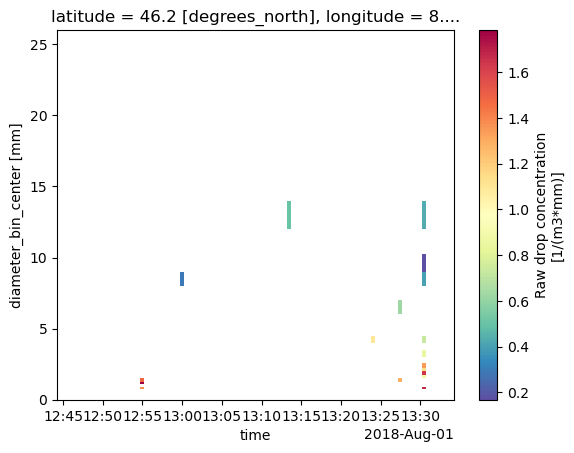

In [ ]:
ds["raw_drop_concentration"].where(ds["raw_drop_concentration"] > 0).plot.pcolormesh(
    x="time",
    y="diameter_bin_center",
    cmap="Spectral_r",
)

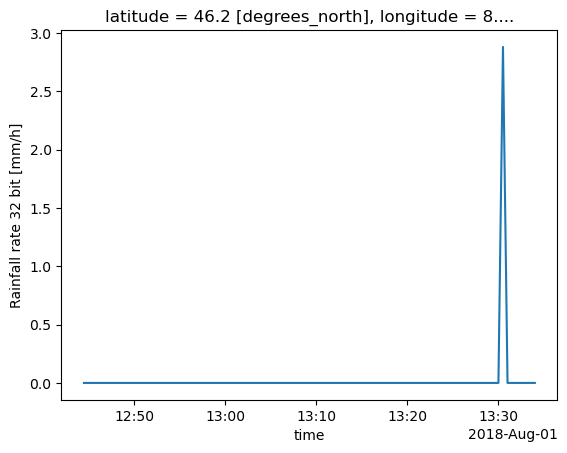

In [ ]:
ds["rainfall_rate_32bit"].plot(x="time")

## 9. Conclusion

You arrived at the end of this tutorial. Well done 👋👋👋 

At this point, you should now be able to create DISDRODB readers for your own stations.
When you think your reader is ready, you can test it following the "[Test the DISDRODB L0 processsing](https://disdrodb.readthedocs.io/en/latest/contribute_data.html#step-8-test-the-disdrodb-l0-processing)" documentation of the [How to Contribute New Data to DISDRODB](https://disdrodb.readthedocs.io/en/latest/contribute_data.html) guidelines.

Do not hesitate to open a [GitHub Issue](https://github.com/ltelab/disdrodb/issues) if you need any clarification. 

The DISDRODB team hope you enjoyed this tutorial 